# Pull Request Speed
This notebook answers one of the research questions: how do repositories using bots affect the amount of time it takes to close a pull request?

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Import data and parse date time columns
date_columns = ['date', 'issue_created_at', 'issue_closed_at', 'pull_request_created_at', 'pull_request_closed_at']
df = pd.read_csv('data/preprocessed_data.csv', parse_dates=date_columns)
df.head()

C:\Users\annik\AppData\Local\Temp\ipykernel_12872\4010154183.py:3: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/preprocessed_data.csv', parse_dates=date_columns)


,date,activity,contributor,repository,is_bot,issue_created_at,issue_is_closed,issue_closed_at,pull_request_created_at,pull_request_is_closed,pull_request_closed_at,amount_of_comments,pr_commits,pr_changed_files,pushed_commits,pushed_distinct_commits,comment_length
0,2022-11-25 09:55:19+00:00,Commenting pull request,AmplabJenkins,apache/spark,True,NaT,NaN,NaT,2022-11-24 04:42:12+00:00,False,NaT,2,NaN,NaN,NaN,NaN,40.0
1,2022-11-25 09:55:23+00:00,Commenting pull request,AmplabJenkins,apache/spark,True,NaT,NaN,NaT,2022-11-24 04:37:11+00:00,False,NaT,1,NaN,NaN,NaN,NaN,40.0
2,2022-11-25 09:55:26+00:00,Commenting pull request,AmplabJenkins,apache/spark,True,NaT,NaN,NaT,2022-11-24 04:05:07+00:00,False,NaT,3,NaN,NaN,NaN,NaN,40.0
3,2022-11-25 09:55:27+00:00,Commenting pull request,analysis-bot,facebook/react-native,True,NaT,NaN,NaT,2022-11-25 09:23:54+00:00,False,NaT,1,NaN,NaN,NaN,NaN,204.0
4,2022-11-25 09:55:47+00:00,Pushing commits,neos-bot,neos/neos-ui-compiled,True,NaT,NaN,NaT,NaT,NaN,NaT,0,NaN,NaN,1.0,1.0,NaN


## Feature engineering
Add a column for `pull_request_time` that contains the time difference between `pull_request_created_at` and `pull_request_closed_at`

In [3]:
# Add pull_request_time
df['pull_request_time'] = (df['pull_request_closed_at'] - df['pull_request_created_at']).abs()
df.head()

,date,activity,contributor,repository,is_bot,issue_created_at,issue_is_closed,issue_closed_at,pull_request_created_at,pull_request_is_closed,pull_request_closed_at,amount_of_comments,pr_commits,pr_changed_files,pushed_commits,pushed_distinct_commits,comment_length,pull_request_time
0,2022-11-25 09:55:19+00:00,Commenting pull request,AmplabJenkins,apache/spark,True,NaT,NaN,NaT,2022-11-24 04:42:12+00:00,False,NaT,2,NaN,NaN,NaN,NaN,40.0,NaT
1,2022-11-25 09:55:23+00:00,Commenting pull request,AmplabJenkins,apache/spark,True,NaT,NaN,NaT,2022-11-24 04:37:11+00:00,False,NaT,1,NaN,NaN,NaN,NaN,40.0,NaT
2,2022-11-25 09:55:26+00:00,Commenting pull request,AmplabJenkins,apache/spark,True,NaT,NaN,NaT,2022-11-24 04:05:07+00:00,False,NaT,3,NaN,NaN,NaN,NaN,40.0,NaT
3,2022-11-25 09:55:27+00:00,Commenting pull request,analysis-bot,facebook/react-native,True,NaT,NaN,NaT,2022-11-25 09:23:54+00:00,False,NaT,1,NaN,NaN,NaN,NaN,204.0,NaT
4,2022-11-25 09:55:47+00:00,Pushing commits,neos-bot,neos/neos-ui-compiled,True,NaT,NaN,NaT,NaT,NaN,NaT,0,NaN,NaN,1.0,1.0,NaN,NaT


In [4]:
# Count the amount of entries that don't have a PR time
print((df['pull_request_time'].isna().sum() / len(df)) * 100, "%")

91.97693965962954 %


Observation:
- Only 8% of the entries seem to have recordings of closed PRs

In [5]:
# Filter out NaT values
filtered_df = df.dropna(subset=['pull_request_time'])

# Reset the index after removing rows
filtered_df.reset_index(drop=True, inplace=True)

filtered_df.head()

,date,activity,contributor,repository,is_bot,issue_created_at,issue_is_closed,issue_closed_at,pull_request_created_at,pull_request_is_closed,pull_request_closed_at,amount_of_comments,pr_commits,pr_changed_files,pushed_commits,pushed_distinct_commits,comment_length,pull_request_time
0,2022-11-25 10:00:30+00:00,Commenting pull request,gitguardian[bot],FedML-AI/FedML,True,NaT,NaN,NaT,2022-11-25 10:00:19+00:00,True,2022-11-25 10:00:26+00:00,1,NaN,NaN,NaN,NaN,4853.0,0 days 00:00:07
1,2022-11-25 10:01:41+00:00,Closing pull request,restyled-io[bot],tediorewf/computer-graphics,True,NaT,NaN,NaT,2022-11-25 10:01:10+00:00,True,2022-11-25 10:01:40+00:00,1,2.0,2.0,NaN,NaN,0.0,0 days 00:00:30
2,2022-11-25 10:08:50+00:00,Commenting pull request,openshift-cherrypick-robot,openshift/assisted-service,True,NaT,NaN,NaT,2022-11-25 06:12:32+00:00,True,2022-11-25 09:25:16+00:00,6,NaN,NaN,NaN,NaN,568.0,0 days 03:12:44
3,2022-11-25 10:10:02+00:00,Closing pull request,jujubot,juju/juju,True,NaT,NaN,NaT,2022-11-25 06:31:12+00:00,True,2022-11-25 10:10:01+00:00,2,1.0,2.0,NaN,NaN,0.0,0 days 03:38:49
4,2022-11-25 10:14:45+00:00,Commenting pull request,tykbot[bot],TykTechnologies/tyk-docs,True,NaT,NaN,NaT,2022-11-24 17:39:08+00:00,True,2022-11-24 19:50:42+00:00,3,NaN,NaN,NaN,NaN,51.0,0 days 02:11:34


## Statistical analysis

In [6]:
# Group by 'is_bot' and calculate statistical summary
filtered_df.groupby('is_bot').describe().transpose()

is_bot                                               False  \
amount_of_comments      count                      32618.0   
                        mean                       2.10951   
                        std                       3.294922   
                        min                            0.0   
                        25%                            1.0   
                        50%                            1.0   
                        75%                            2.0   
                        max                          240.0   
pr_commits              count                      28833.0   
                        mean                      2.937121   
                        std                      14.953075   
                        min                            0.0   
                        25%                            1.0   
                        50%                            1.0   
                        75%                            2.0   
                        max                          827.0   
pr_changed_files        count                      28833.0   
                        mean                      7.780425   
                        std                     162.312062   
                        min                            0.0   
                        25%                            1.0   
                        50%                            2.0   
                        75%                            4.0   
                        max                        25587.0   
pushed_commits          count                          0.0   
                        mean                           NaN   
                        std                            NaN   
                        min                            NaN   
                        25%                            NaN   
                        50%                            NaN   
                        75%                            NaN   
                        max                            NaN   
pushed_distinct_commits count                          0.0   
                        mean                           NaN   
                        std                            NaN   
                        min                            NaN   
                        25%                            NaN   
                        50%                            NaN   
                        75%                            NaN   
                        max                            NaN   
comment_length          count                      32618.0   
                        mean                     25.346894   
                        std                     368.296263   
                        min                            0.0   
                        25%                            0.0   
                        50%                            0.0   
                        75%                            0.0   
                        max                        59997.0   
pull_request_time       count                        32618   
                        mean    27 days 07:33:33.550984119   
                        std    143 days 22:55:22.045861896   
                        min                0 days 00:00:01   
                        25%                0 days 00:37:56   
                        50%         0 days 08:47:18.500000   
                        75%         4 days 01:13:01.750000   
                        max             3854 days 05:57:26   

is_bot                                               True  
amount_of_comments      count                     48850.0  
                        mean                     5.176704  
                        std                      7.821172  
                        min                           0.0  
                        25%                           1.0  
                        50%                           3.0  
                        75%                  

Observations:
- although we filtered out 92% of the data, there seem to be enough human and bot repositories left to draw conclusions
- the average time it takes bots to close a pull request is about 2x as fast as human. Nevertheless, looking at the different quartiles, it seems that the human average is pulled up by some outliers. For instance, the 75% quartile shows very similar times
- the pr_commits and pr_changed files show that the average bot has more commits and file changes, but again looking at the quartiles, it seems to be influenced by outliers

## Outlier removal

In [7]:
# Convert timedelta64[ns] to hours
filtered_df['pull_request_time_hours'] = filtered_df['pull_request_time'].dt.total_seconds() / 3600

# Remove outliers (>20 days pull request time)
filtered_20_df = filtered_df[filtered_df['pull_request_time_hours'] <= 480]

# Remove outliers (>10 days pull request time)
filtered_10_df = filtered_df[filtered_df['pull_request_time_hours'] <= 240]

C:\Users\annik\AppData\Local\Temp\ipykernel_12872\453492178.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['pull_request_time_hours'] = filtered_df['pull_request_time'].dt.total_seconds() / 3600


In [8]:
# Group by 'is_bot' and calculate statistical summary
filtered_20_df.groupby('is_bot').describe().transpose()

is_bot                              False        True
amount_of_comments      count     28566.0     44087.0
                        mean     1.878317     4.54363
                        std       2.25083    5.578533
                        min           0.0         0.0
                        25%           1.0         1.0
...                                   ...         ...
pull_request_time_hours min      0.000278         0.0
                        25%      0.428681    0.234722
                        50%      4.731389    3.167778
                        75%     33.159167   48.357639
                        max    479.873056  479.808611

[64 rows x 2 columns]

Observation:
- humans seem to be faster when we remove PRs that last for more than 20 days

## Visual analysis

<AxesSubplot:xlabel='is_bot', ylabel='pull_request_time_hours'>

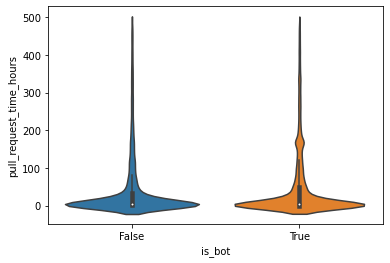

In [9]:
# Pull request time 20 days
sns.violinplot(data=filtered_20_df, x="is_bot", y="pull_request_time_hours")

<AxesSubplot:xlabel='is_bot', ylabel='pull_request_time_hours'>

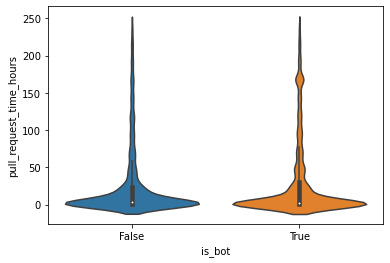

In [10]:
# Pull request time 10 days
sns.violinplot(data=filtered_10_df, x="is_bot", y="pull_request_time_hours")

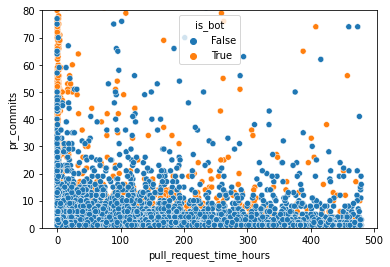

In [11]:
# Pull request commits
plt.ylim(0, 80)
sns.scatterplot(data=filtered_20_df, x="pull_request_time_hours", y="pr_commits", hue="is_bot")
plt.show()

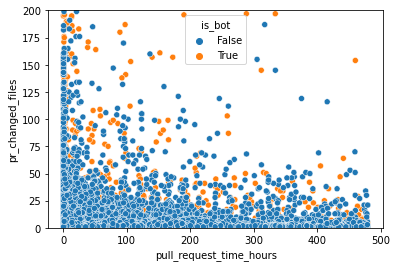

In [13]:
# Pull request changed files
plt.ylim(0, 200)
sns.scatterplot(data=filtered_20_df, x="pull_request_time_hours", y="pr_changed_files", hue="is_bot")
plt.show()